## An Initial Notebook To Get Started

Copying code from https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification

In [22]:
!pip install --upgrade --quiet tensorflow-federated
!pip install --upgrade --quiet nest-asyncio



DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [23]:
import nest_asyncio
nest_asyncio.apply()

In [24]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from typing import Callable, List, OrderedDict

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [26]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()


In [27]:
len(emnist_train.client_ids)

3383

In [28]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

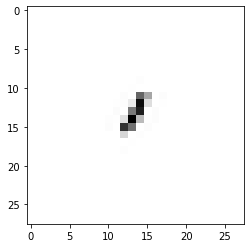

In [29]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

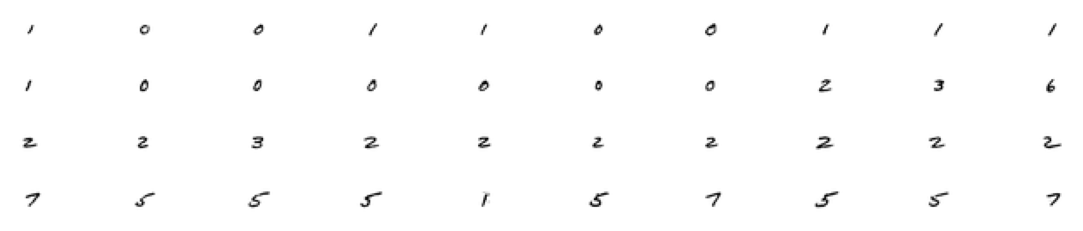

In [30]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

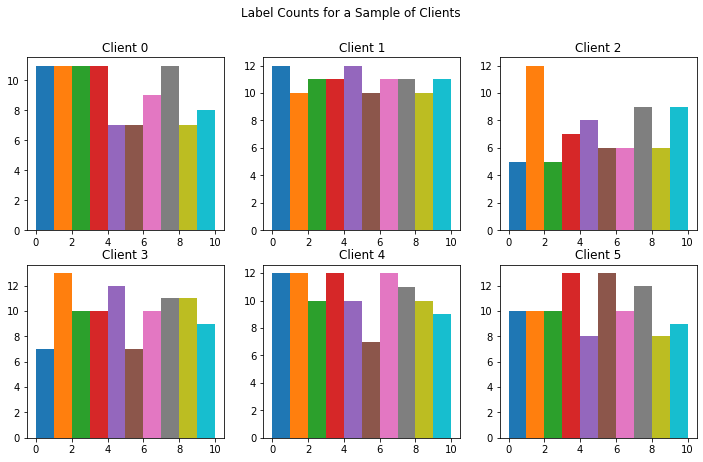

In [60]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

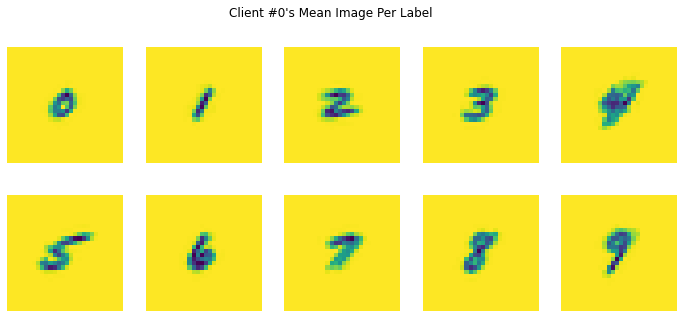

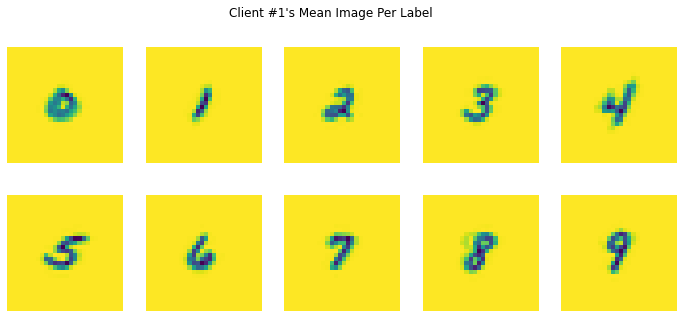

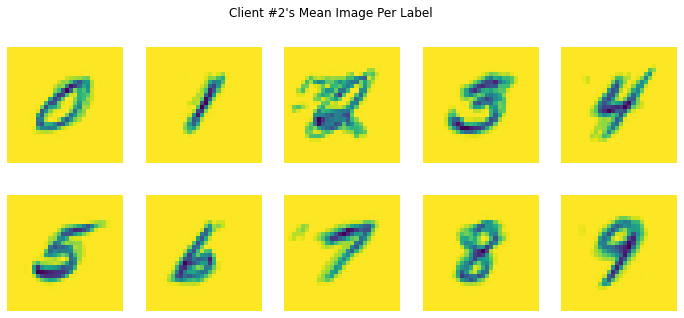

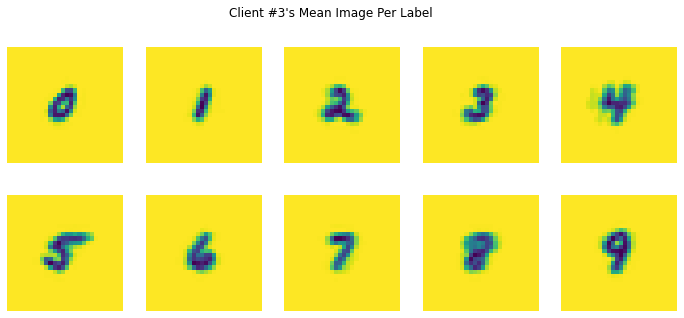

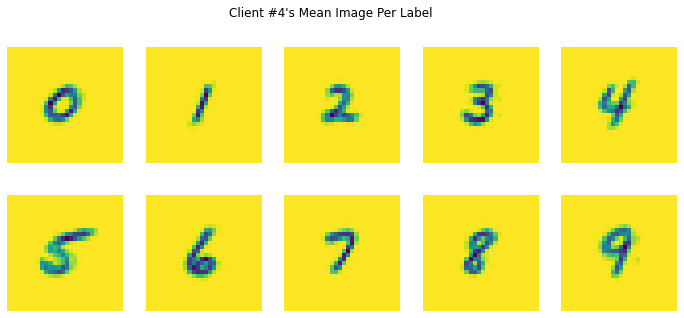

In [32]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

In [33]:
NUM_CLIENTS = 10 #Number of clients, pretty straightforward
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [34]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[2],
                     [1],
                     [5],
                     [7],
                     [1],
                     [7],
                     [7],
                     [1],
                     [4],
                     [7],
                     [4],
                     [2],
                     [2],
                     [5],
                     [4],
                     [1],
                     [1],
                     [0],
                     [0],
                     [9]], dtype=int32))])

In [35]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [36]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 10
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


In [37]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    ])

In [38]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [39]:
sys.setrecursionlimit(1000000)
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [40]:
print(iterative_process.initialize.type_signature.formatted_representation())

( -> <
  model=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  optimizer_state=<
    int64
  >,
  delta_aggregate_state=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  model_broadcast_state=<>
>@SERVER)


In [41]:
state = iterative_process.initialize()

In [42]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12345679), ('loss', 3.119374), ('num_examples', 4860), ('num_batches', 248)]))])


In [43]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.13518518), ('loss', 2.9834733), ('num_examples', 4860), ('num_batches', 248)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14382716), ('loss', 2.8616652), ('num_examples', 4860), ('num_batches', 248)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.17407407), ('loss', 2.7957027), ('num_examples', 4860), ('num_batches', 248)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.19917695), ('loss', 2.614657), ('n

In [44]:
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    state, metrics = iterative_process.next(state, federated_train_data)
    for name, value in metrics['train'].items():
      tf.summary.scalar(name, value, step=round_num)


In [46]:
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

events.out.tfevents.1653074028.MacBook-Pro.local.21051.0.v2


Reusing TensorBoard on port 51493 (pid 48223), started 0:04:06 ago. (Use '!kill 48223' to kill it.)

In [ ]:
# Uncomment and run this cell to clean your directory of old output for
# future graphs from this directory. We don't run it by default so that if 
# you do a "Runtime > Run all" you don't lose your results.

# !rm -R /tmp/logs/scalars/*

In [47]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

## Customizing the implementation, Non-Keras

In [48]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))

In [49]:
def predict_on_batch(variables, x):
  return tf.nn.softmax(tf.matmul(x, variables.weights) + variables.bias)

def mnist_forward_pass(variables, batch):
  y = predict_on_batch(variables, batch['x'])
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

In [50]:
def predict_on_batch(variables, x):
  return tf.nn.softmax(tf.matmul(x, variables.weights) + variables.bias)

def mnist_forward_pass(variables, batch):
  y = predict_on_batch(variables, batch['x'])
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

In [51]:
def get_local_unfinalized_metrics(variables):
  return collections.OrderedDict(
      num_examples=[variables.num_examples],
      loss=[variables.loss_sum, variables.num_examples],
      accuracy=[variables.accuracy_sum, variables.num_examples])

def get_metric_finalizers():
  return collections.OrderedDict(
      num_examples=tf.function(func=lambda x: x[0]),
      loss=tf.function(func=lambda x: x[0] / x[1]),
      accuracy=tf.function(func=lambda x: x[0] / x[1]))

In [52]:
from typing import Callable, List, OrderedDict

class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def predict_on_batch(self, x, training=True):
    del training
    return predict_on_batch(self._variables, x)

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_unfinalized_metrics(
      self) -> OrderedDict[str, List[tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to unfinalized values."""
    return get_local_unfinalized_metrics(self._variables)

  def metric_finalizers(
      self) -> OrderedDict[str, Callable[[List[tf.Tensor]], tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to finalizers."""
    return get_metric_finalizers()

  @tf.function
  def reset_metrics(self):
    """Resets metrics variables to initial value."""
    for var in self.local_variables:
      var.assign(tf.zeros_like(var))

In [53]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))
state = iterative_process.initialize()
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 3.0708053), ('accuracy', 0.12777779)]))])


In [54]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 3.011699), ('accuracy', 0.13024691)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.7408307), ('accuracy', 0.15576132)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.6761014), ('accuracy', 0.17921811)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('num_examples', 4860.0), ('loss', 2.6755672), ('accuracy', 0.1855967)]))])
round  6, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weig

In [55]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)
print(evaluation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=float32[?,784],
    y=int32[?,1]
  >*}@CLIENTS
> -> <
  eval=<
    num_examples=float32,
    loss=float32,
    accuracy=float32
  >
>@SERVER)


In [56]:
train_metrics = evaluation(state.model, federated_train_data)
str(train_metrics)

"OrderedDict([('eval', OrderedDict([('num_examples', 4860.0), ('loss', 1.7510433), ('accuracy', 0.2788066)]))])"

In [57]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>)

In [58]:
test_metrics = evaluation(state.model, federated_test_data)
str(test_metrics)

"OrderedDict([('eval', OrderedDict([('num_examples', 580.0), ('loss', 1.8361605), ('accuracy', 0.2413793)]))])"